# Embrapa Wine Grape Instance Segmentation Dataset (WGISD)

## Why was the dataset created?

Embrapa WGISD (Wine Grape Instance Segmentation Dataset) was created to provide images and annotation to study
object detection and instance segmentation in image-based monitoring and field robotics for viticulture. It provides
instances from five different grape varieties taken on field. These instances shows variance in grape pose, illumination
and focus, including genetic and phenological variations as shape, color and compactness.

This notebook shows:

1. the dataset structure;
2. how to load data (using Torch `Dataset` class in 'torch.utils.data`);
3. how to visualize data using Matplotlib. 

## Dataset Composition

In [1]:
varietals = ['CDY', 'CFR', 'CSV', 'SVB', 'SYH']

### How many instances of each type are there?

In [2]:
import os
import numpy as np

In [3]:
instances = {v: [] for v in varietals}

for dirname, dirnames, filenames in os.walk('./data/'):
    if dirname == './data/':
        for filename in [f for f in filenames if f.endswith('.txt')]:
            for v in varietals:
                if filename.startswith(v):
                    instances[v].append(filename[:-4])

In [4]:
n_vimages = {v: len(inst_v) for v, inst_v in instances.items()}
n_vimages

{'CDY': 65, 'CFR': 65, 'CSV': 57, 'SVB': 65, 'SYH': 48}

In [5]:
n_images = np.array([n for __, n in n_vimages.items()]).sum()
n_images

300

### Bounding boxes

In [6]:
n_iboxes = {v: {} for v in varietals}

for v in varietals:
    for ii in instances[v]:
        annot_file = os.path.join('./data', ii + '.txt')
        bboxes = np.loadtxt(annot_file)
        n_iboxes[v][ii] = bboxes.shape[0]

In [7]:
n_vboxes = {v: np.array([n for ii, n in n_iboxes[v].items()]).sum() for v in varietals}
n_vboxes

{'CDY': 840, 'CFR': 1069, 'CSV': 643, 'SVB': 1316, 'SYH': 563}

### Masks

In [8]:
n_imasks = {v: {} for v in varietals}

for v in varietals:
    for ii in instances[v]:
        annot_file = os.path.join('./data', ii + '.npz')
        if os.path.isfile(annot_file):
            masks = np.load(annot_file)['arr_0']
            n_imasks[v][ii] = masks.shape[2]

There is a mask for each bounding box in the masked images?

In [9]:
for v in varietals:
    for ii in n_imasks[v]:
        assert(n_imasks[v][ii] == n_iboxes[v][ii])

In [10]:
n_vmasks = {v: np.array([n for ii, n in n_imasks[v].items()]).sum() for v in varietals}
n_vmasks

{'CDY': 308, 'CFR': 513, 'CSV': 306, 'SVB': 608, 'SYH': 285}

In [11]:
import pandas as pd

In [12]:
n_vimages

{'CDY': 65, 'CFR': 65, 'CSV': 57, 'SVB': 65, 'SYH': 48}

In [13]:
df = pd.DataFrame(index=varietals, columns=['Images', 'BoxedBunches', 'MaskedBunches'])
for v, val in n_vimages.items():
    df.loc[v, 'Images'] = val
    df.loc[v, 'BoxedBunches'] = n_vboxes[v]
    df.loc[v, 'MaskedBunches'] = n_vmasks[v]
     
df

,Images,BoxedBunches,MaskedBunches
CDY,65,840,308
CFR,65,1069,513
CSV,57,643,306
SVB,65,1316,608
SYH,48,563,285


In [14]:
df.sum()

Images            300
BoxedBunches     4431
MaskedBunches    2020
dtype: object

### Are there recommended data splits or evaluation measures?

In [15]:
with open('train.txt', 'r') as fp:
    train = fp.readlines()
train = set([i[:-1] for i in train])

len(train)

242

In [16]:
with open('test.txt', 'r') as fp:
    test = fp.readlines()
test = set([i[:-1] for i in test])

len(test)

58

Assert train and test are _disjoints_ :

In [17]:
train.intersection(test)

set()

In [18]:
data = []
for v, val in n_iboxes.items():
    for i in val:
        if i in train:
            sp = 'Train'
        else:
            sp = 'Test'
            
        if i in n_imasks[v]:
            nm = n_imasks[v][i]
        else:
            nm = 0
            
        data.append((i, v, sp, 1, n_iboxes[v][i], nm))

dfi = pd.DataFrame(data, 
                   columns=['Inst', 'Variety', 'Split', 'Image', 'BoxedBunches', 'MaskedBunches']).set_index('Inst')

In [19]:
dfi.groupby(['Split']).sum()

,Image,BoxedBunches,MaskedBunches
Split,,,
Test,58,850,408
Train,242,3581,1612


In [20]:
dfi.groupby(['Split']).sum().sum()

Image             300
BoxedBunches     4431
MaskedBunches    2020
dtype: int64

## A Dataset class for PyTorch data loaders

This example shows how to load the data, getting an iterable dataset. This example uses PyTorch, but could be adapted to other deep learning frameworks.

In [21]:
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

In [22]:
torch.__version__

'1.8.1+cpu'

The following example creates a `Dataset` object for our *masked* set.

In [23]:
class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms
        
        # Let's load the dataset subset defined by source
        if source not in ('train', 'test'):
            print('source should by "train" or "test"')
            return None

        source_path = os.path.join(root, f'{source}_masked.txt')
        with open(source_path, 'r') as fp:
          # Read all lines in file
          lines = fp.readlines()
          # Recover the items ids, removing the \n at the end
          ids = [l.rstrip() for l in lines]

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

    def __getitem__(self, idx):
        # Load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = Image.open(img_path).convert("RGB")

        # From TorchVision documentation:
        # 
        # The models expect a list of Tensor[C, H, W], in the range 0-1. 
        # The models internally resize the images so that they have a minimum 
        # size of 800. This option can be changed by passing the option min_size 
        # to the constructor of the models.
        
        if self.transforms is None:
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # Move the channels axe to the first position, getting C, H, W instead H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)  
        else:
            img = np.array(img)
            img = self.transforms(torch.as_tensor(img, dtype=torch.uint8))
            img = np.array(img)
            # Normalize
            img = (img - img.min()) / np.max([img.max() - img.min(), 1])
            # move o eixo final para frente, para termos C, H, W e não H, W, C
            img = np.moveaxis(img, -1, 0)
            img = torch.as_tensor(img, dtype=torch.float32)  

        # Loading masks:
        #
        # As seen in WGISD (README.md):
        # 
        # After assigning the NumPy array to a variable M, the mask for the 
        # i-th grape cluster can be found in M[:,:,i]. The i-th mask corresponds 
        # to the i-th line in the bounding boxes file.
        #
        # According to Mask RCNN documentation in Torchvision:
        #
        # During training, the model expects both the input tensors, as well as 
        # a targets (list of dictionary), containing:
        # (...) 
        # masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each 
        # instance
        #
        # WGISD provides [H, W, N] masks, but Torchvision asks for [N, H, W]. Lett's
        # employ NumPy moveaxis.
        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        masks = np.moveaxis(wgisd_masks, -1, 0) 

        num_objs = masks.shape[0]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        assert(wgisd_boxes.shape[0] == num_objs)

        # IMPORTANT: Torchvision considers 0 as background. So, let's make grapes
        # grapes as class 1
        labels = np.ones(num_objs, dtype=np.int64)

        # According to WGISD:
        #
        # These text files follows the "YOLO format"
        # 
        # CLASS CX CY W H
        # 
        # class is an integer defining the object class – the dataset presents 
        # only the grape class that is numbered 0, so every line starts with 
        # this "class zero" indicator. The center of the bounding box is the 
        # point (c_x, c_y), represented as float values because this format 
        # normalizes the coordinates by the image dimensions. To get the 
        # absolute position, use (2048 c_x, 1365 c_y). The bounding box 
        # dimensions are given by W and H, also normalized by the image size.
        #
        # Torchvision's Mask R-CNN expects absolute coordinates.
        _, height, width = img.shape

        boxes = []
        for box in wgisd_boxes:
            x1 = box[0] - box[2]/2
            x2 = box[0] + box[2]/2
            y1 = box[1] - box[3]/2
            y2 = box[1] + box[3]/2
            boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # ou poderíamos usar
        # labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

The dataset class in action:

In [24]:
# Here, the WGISD root is ./
dataset = WGISDMaskedDataset('./')

In [25]:
img, target = dataset[42]
print(img.shape)

torch.Size([3, 1365, 2048])


In [26]:
for k, v in target.items():
    print(k, v.shape, v.dtype)

boxes torch.Size([11, 4]) torch.float32
labels torch.Size([11]) torch.int64
masks torch.Size([11, 1365, 2048]) torch.uint8
image_id torch.Size([1]) torch.int64


## Visualization

In [27]:
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon

from skimage.color import label2rgb

import colorsys
import random

In [28]:
def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def show_item(img, boxes, mask):

    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2)
    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)

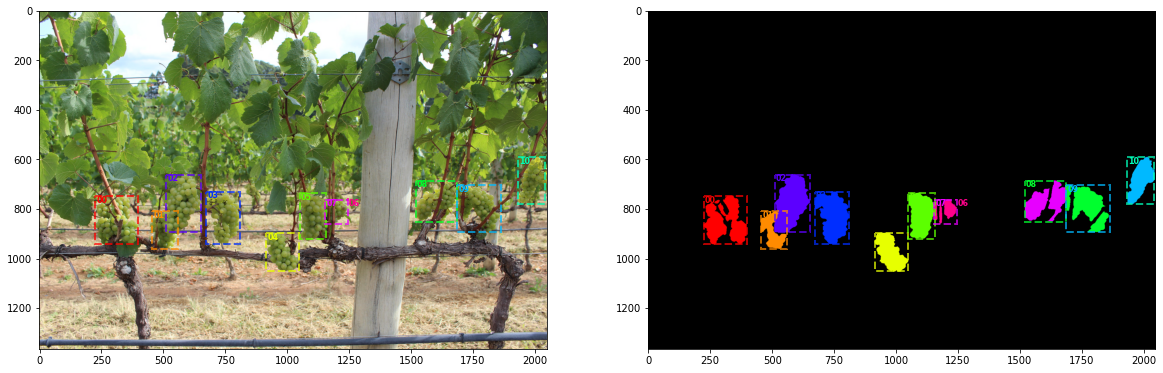

In [29]:
show_item(img.numpy(), target['boxes'].numpy(), target['masks'].numpy())

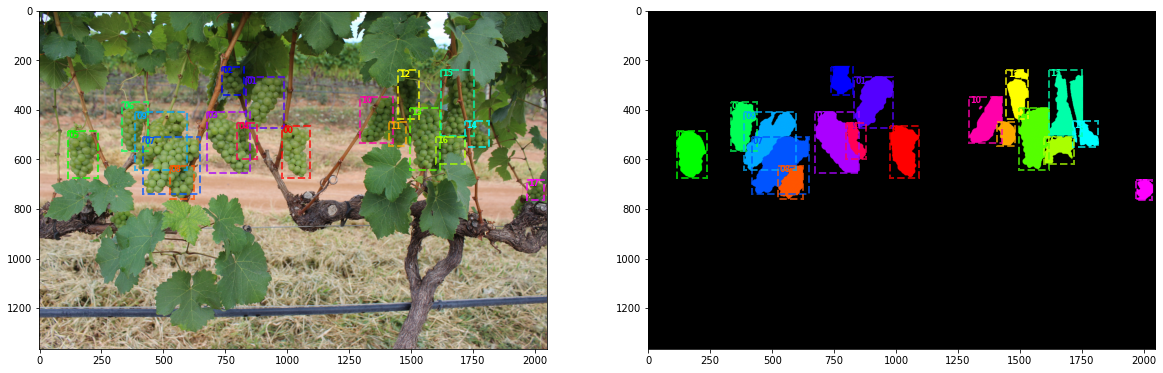

In [30]:
img, target = dataset[16]
show_item(img.numpy(), target['boxes'].numpy(), target['masks'].numpy())

## Contrib - berries annotations

In [31]:
from random import choice

In [32]:
CONTRIB_BERRIES_DIR = './contrib/berries/'

In [33]:
with open('./train.txt') as fp:
    training_ids = [l.rstrip() for l in fp.readlines()]

In [34]:
id = choice(training_ids)

image_path = f'./data/{id}.jpg'
berries_path = f'{CONTRIB_BERRIES_DIR}/{id}-berries.txt'

print(image_path)
print(berries_path)

./data/SVB_1969.jpg
./contrib/berries//SVB_1969-berries.txt


In [35]:
image = np.array(Image.open(image_path))
berries = np.loadtxt(berries_path)
berries

array([[2030.,  779.],
       [2030.,  768.],
       [2034.,  756.],
       ...,
       [  65.,  649.],
       [  77.,  648.],
       [  89.,  685.]])

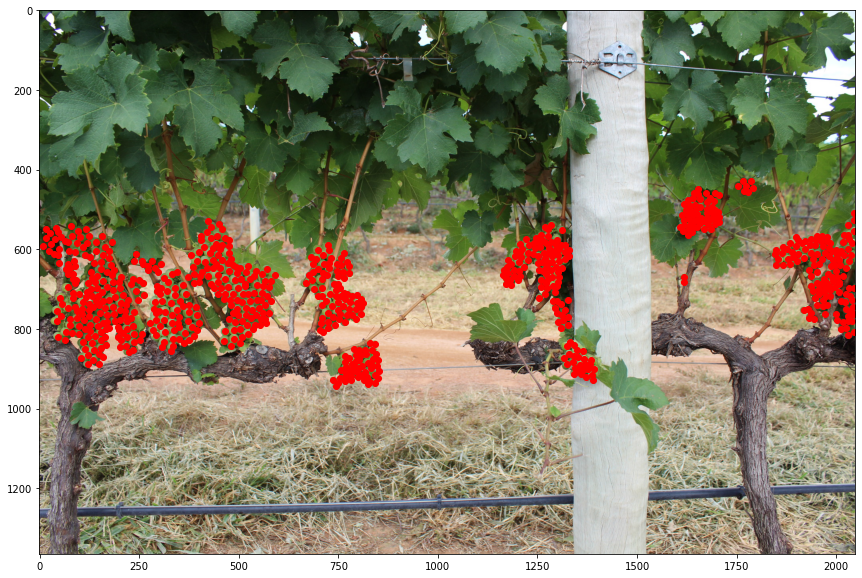

In [36]:
fig, ax = plt.subplots(figsize=(15,10))

plt.imshow(image)
plt.scatter(berries[:,0], berries[:,1], color='r')

In [37]:
with open('./test.txt') as fp:
    test_ids = [l.rstrip() for l in fp.readlines()]

In [38]:
id = choice(test_ids)

image_path = f'./data/{id}.jpg'
berries_path = f'{CONTRIB_BERRIES_DIR}/{id}-berries.txt'

print(image_path)
print(berries_path)

./data/CDY_2039.jpg
./contrib/berries//CDY_2039-berries.txt


In [39]:
image = np.array(Image.open(image_path))
berries = np.loadtxt(berries_path)
berries

array([[1859.,  572.],
       [1818.,  560.],
       [1888.,  552.],
       [1855.,  539.],
       [1825.,  515.],
       [1746.,  584.],
       [1788.,  580.],
       [1743.,  549.],
       [1774.,  542.],
       [1791.,  504.],
       [1893.,  644.],
       [1821.,  643.],
       [1860.,  642.],
       [1881.,  619.],
       [1827.,  603.],
       [1903.,  730.],
       [1863.,  729.],
       [1848.,  695.],
       [1892.,  683.],
       [1816.,  676.],
       [1785.,  698.],
       [1741.,  674.],
       [1770.,  666.],
       [1746.,  633.],
       [1780.,  618.],
       [1762.,  720.],
       [1788.,  750.],
       [1807.,  722.],
       [1828.,  753.],
       [1803.,  792.],
       [1836.,  788.],
       [1842.,  823.],
       [1868.,  766.],
       [1885.,  801.],
       [1913.,  764.],
       [1859., 1059.],
       [1839., 1037.],
       [1809., 1028.],
       [1859., 1023.],
       [1845., 1009.],
       [1822., 1005.],
       [1805.,  987.],
       [1846.,  987.],
       [182

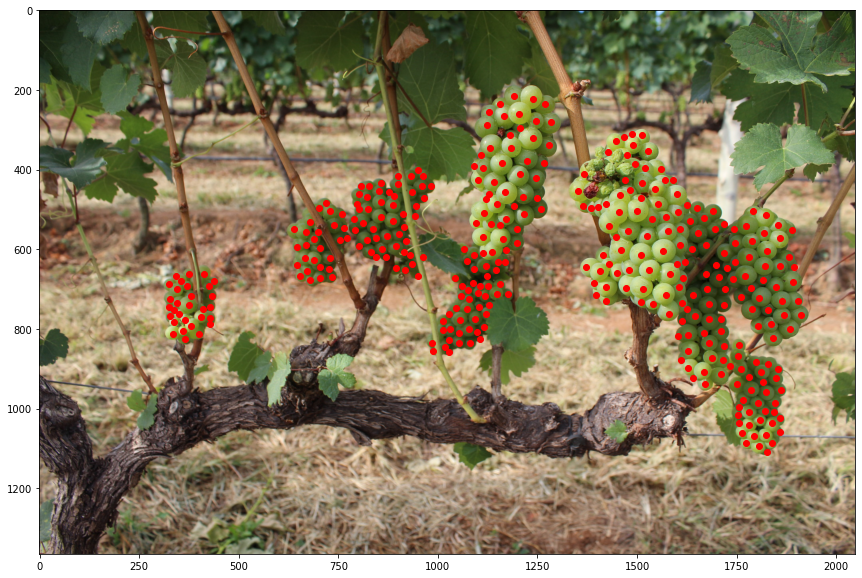

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

plt.imshow(image)
plt.scatter(berries[:,0], berries[:,1], color='r')